In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import math
from scipy.stats import norm
import re
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

VOL_WINDOW = 21

In [28]:
# Load and preprocess SP500 data
sp500 = pd.read_csv("data/sp500.csv", parse_dates=['Date'])
r = pd.read_csv("data/r.csv", parse_dates=['observation_date']).rename(columns={'observation_date': 'Date'})

# Merge rate data and fill missing values
sp500 = sp500.merge(r, on='Date', how='left')
sp500['FEDFUNDS'] = sp500['FEDFUNDS'].ffill()
sp500.loc[sp500['Date'] >= '2024-10-10', 'FEDFUNDS'] = 0.25

# Calculate log returns and rolling volatility
sp500['log_return'] = np.log(sp500['Close/Last'] / sp500['Close/Last'].shift(1))
sp500['sp500_vol'] = sp500['log_return'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)

# Filter out future dates and drop rows with missing values
sp500 = sp500[sp500['Date'] < pd.Timestamp('2025-01-01')].dropna()

# Load Kalshi data
kalshi = pd.read_csv("data/kalshi_trades.csv")

def process_kalshi_grouped(kalshi):
    kalshi['created_time'] = pd.to_datetime(kalshi['created_time']).dt.date
    kalshi = kalshi[['created_time', 'ticker', 'title', 'count', 'yes_price']].rename(
        columns={'created_time': 'Date', 'yes_price': 'contract_price'}
    )

    
    def compute_vwap(group):
        weighted_avg = (group['contract_price'] * group['count']).sum() / group['count'].sum()
        summary = group.iloc[0].copy()
        summary['contract_price'] = weighted_avg
        return summary

    result = kalshi.groupby(['ticker', 'Date']).apply(compute_vwap).reset_index(drop=True)


    # Create empty log_return column
    result['log_return'] = np.nan

    # Get unique tickers
    tickers = result['ticker'].unique()

    # Calculate log returns for each ticker separately
    for ticker in tickers:
        mask = result['ticker'] == ticker
        ticker_data = result.loc[mask, 'contract_price']
        
        # Sort by date (make sure dates are in ascending order)
        ticker_data = ticker_data.sort_index()
        
        # Calculate log returns and assign back to the result DataFrame
        result.loc[mask, 'log_return'] = np.log(ticker_data / ticker_data.shift(1))

    # Define the volatility window
    VOL_WINDOW = 21

    # Calculate the volatility with a dynamic annualization factor based on non-NA days
    def calculate_dynamic_volatility(series):
        # Count the number of non-NA values in the original log_return series
        non_na_count = series.notna().sum()
        
        # If there are no valid observations, return NA
        if non_na_count == 0:
            return pd.Series([np.nan] * len(series))
        
        # Calculate the rolling standard deviation
        rolling_std = series.rolling(window=VOL_WINDOW).std()
        
        # Annualize based on the proportion of non-NA days
        annualization_factor = np.sqrt(365 / non_na_count * VOL_WINDOW)
        print(annualization_factor)
        
        # Return the annualized volatility
        return rolling_std * annualization_factor

    # Apply the custom volatility calculation to each ticker group
    result['contract_vol'] = result.groupby('ticker')['log_return'].transform(calculate_dynamic_volatility)

    return result

# Process and filter Kalshi data
processed_kalshi = process_kalshi_grouped(kalshi)
processed_kalshi = processed_kalshi.groupby('ticker').filter(lambda x: x['contract_price'].max() > 40)

# Filter SP500 data to align with Kalshi date range
min_date = pd.to_datetime(processed_kalshi['Date'].min())
max_date = pd.to_datetime(processed_kalshi['Date'].max())
sp500 = sp500[(sp500['Date'] >= min_date) & (sp500['Date'] <= max_date)]

# Merge processed Kalshi and SP500 data
processed_kalshi['Date'] = pd.to_datetime(processed_kalshi['Date'])
merged = pd.merge(processed_kalshi, sp500, on='Date', how='right').sort_values('Date')

# Function to extract bounds from contract titles
def extract_bounds(text):
    if pd.isna(text):
        return np.nan, np.nan
    if match := re.search(r'between (\d+(?:\.\d+)?) and (\d+(?:\.\d+)?)', text):
        return float(match.group(1)), float(match.group(2))
    if match := re.search(r'above (\d+(?:\.\d+)?)', text):
        return float(match.group(1)), np.inf
    if match := re.search(r'below (\d+(?:\.\d+)?)', text):
        return -np.inf, float(match.group(1))
    return np.nan, np.nan


# Apply bounds extraction
merged['lower_bound'], merged['upper_bound'] = zip(*merged['title'].map(extract_bounds))

# Map years to known expiration dates
expiration_mapping = {
    '2': pd.Timestamp("2022-12-30"),
    '3': pd.Timestamp("2023-12-29"),
    '4': pd.Timestamp("2024-12-31"),
}

# Extract the second-to-last character from the title column
merged['expiration_year'] = merged['title'].str[-2]
# Map the extracted character to its corresponding expiration date
merged['expiration_date'] = merged['expiration_year'].map(expiration_mapping)

merged = merged.drop(['Open','High','Low', 'expiration_year'],axis=1)
# Preview result
merged.tail()


9.496129242393202
9.228578799938084
7.926403273393237
7.678641706808468
8.093999043292538
7.70834642781205
7.245688373094719
7.172374294481168
6.878576510791663
6.714777382320105
5.9026188332729985
5.862780680651208
5.16791225478633
8.463776581331267
5.158932383093748
14.59166428707386
11.302654555457314
9.668278531160423
8.503606338178937
8.889354226078575
8.584982415644372
8.71154917961845
8.347563607533528
9.280279926037682
11.20962701007121
12.025915412534463
15.476797149281243
19.576771950451892
12.381437719424994
22.60530911091463
10.61699525455739
8.843884085303566
8.059629465344177
6.899905481394214
6.599328478234461
5.929633248246944
5.998826176257965
6.144804365450145
6.0851446578734985
5.7981394474979275
5.760366149978505
5.772875103145895
6.419476413178479
8.347563607533528
7.6202481467588585
10.776658277794821
10.859239242372226
10.539779718843233
12.770477923044961
14.59166428707386
12.140998564938807
13.842868199907128
11.69935895679759
10.61699525455739
9.22857879993808

,Date,ticker,title,count,contract_price,log_return_x,contract_vol,Close/Last,FEDFUNDS,log_return_y,sp500_vol,lower_bound,upper_bound,expiration_date
4,2024-12-24,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,200.0,96.437882,0.048187,0.255915,6040.04,0.25,0.000406,0.146516,5799.99,inf,2024-12-31
3,2024-12-26,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,300.0,96.181593,-0.000191,0.230219,6037.59,0.25,0.011117,0.147494,5799.99,inf,2024-12-31
2,2024-12-27,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,300.0,96.739519,0.005784,0.224028,5970.84,0.25,0.010760,0.142756,5799.99,inf,2024-12-31
1,2024-12-30,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,44.0,93.161722,-0.008958,0.216891,5906.94,0.25,0.004294,0.138238,5799.99,inf,2024-12-31
0,2024-12-31,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,16.0,97.616681,0.046711,0.222802,5881.63,0.25,0.002226,0.140340,5799.99,inf,2024-12-31


In [29]:
merged['ticker'].value_counts()

ticker
INXD-24DEC31-T5799.99    242
INXY-23DEC29-B4600       179
INXY-23DEC29-B4800       174
INXY-22DEC30-B4100        86
INXY-22DEC30-B3700        86
INXY-22DEC30-B3900        81
Name: count, dtype: int64

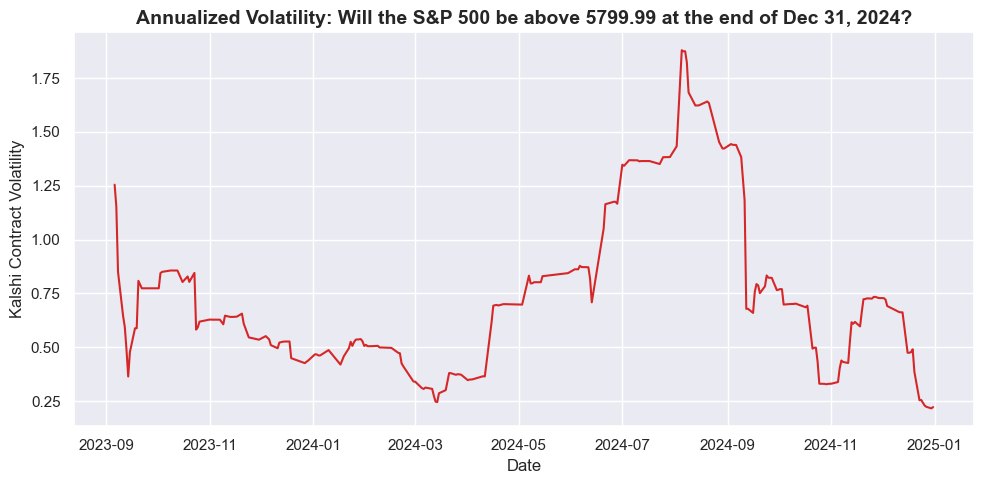

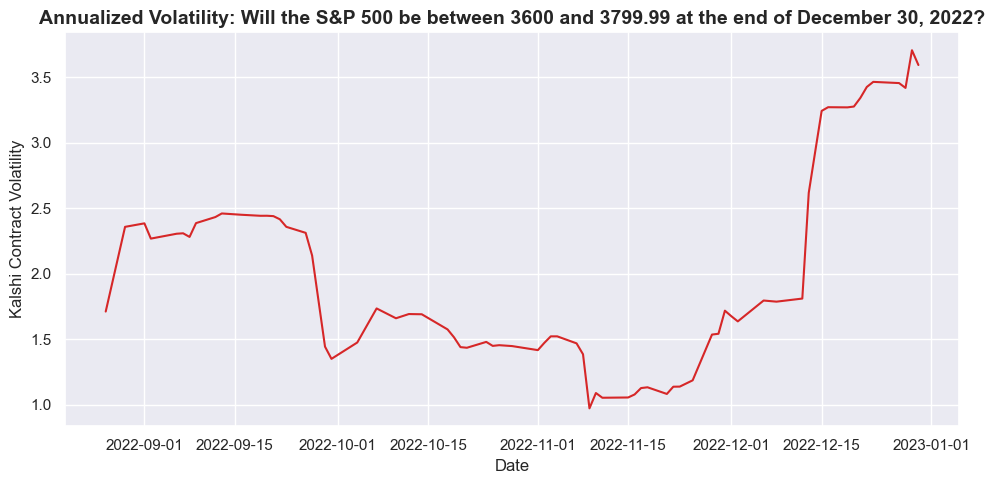

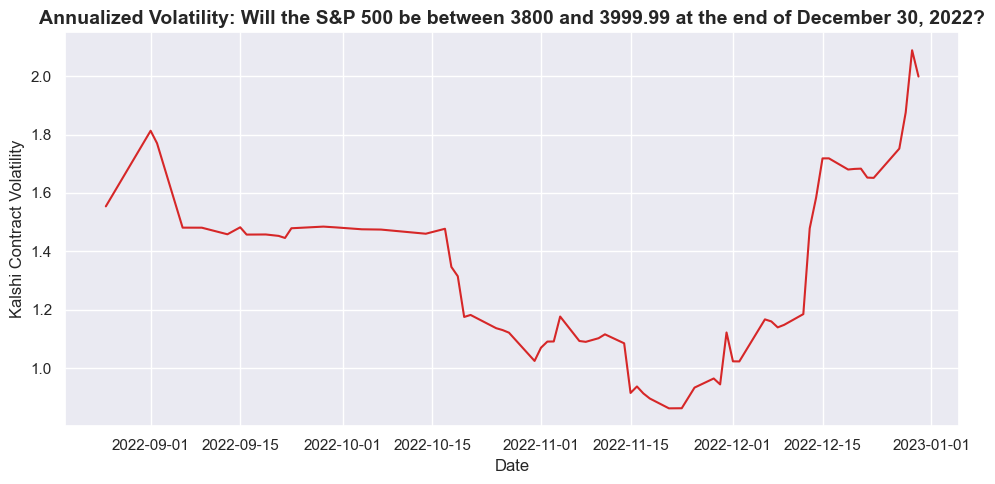

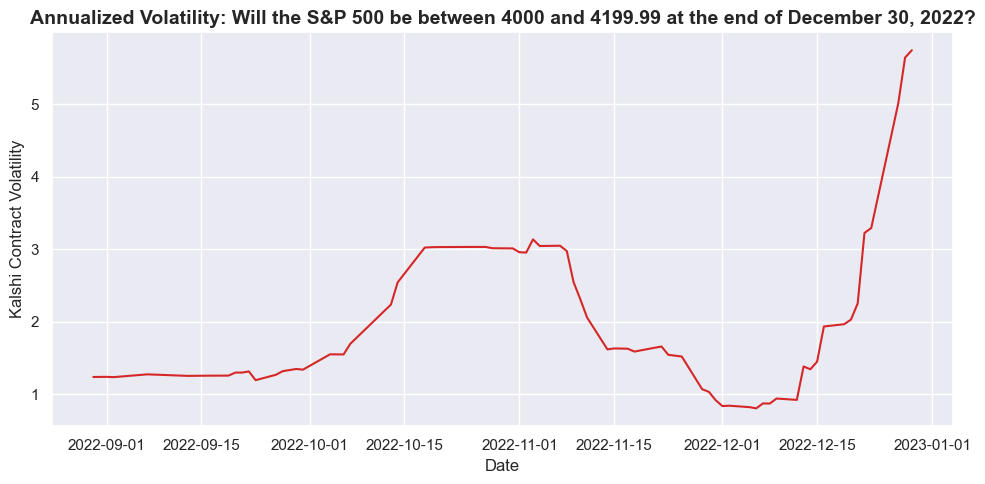

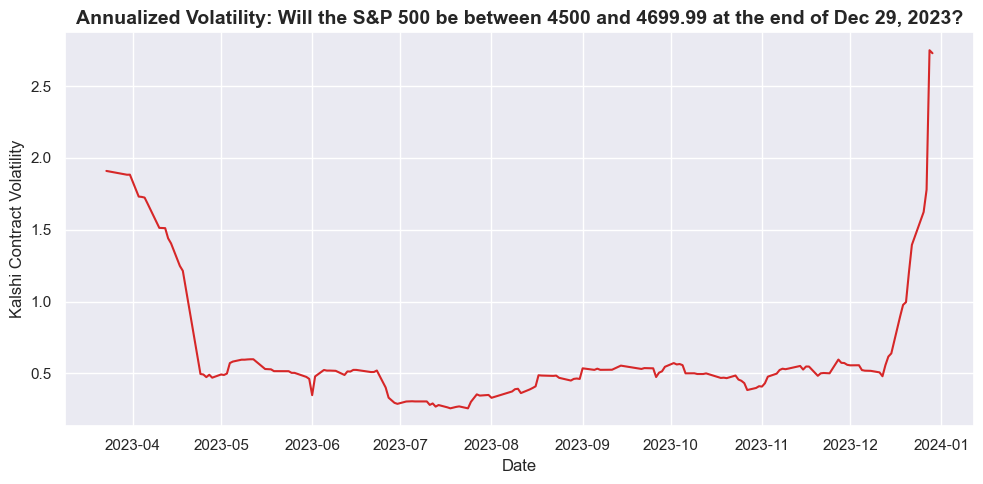

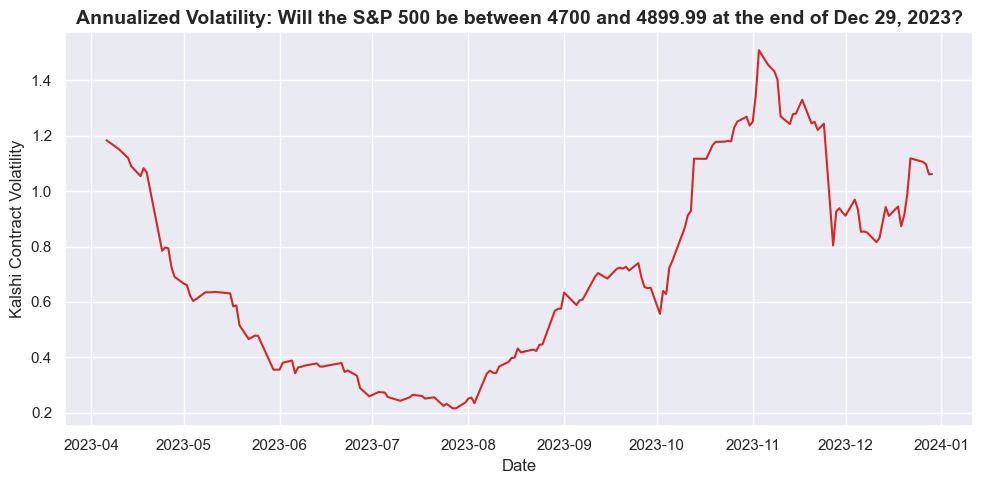

In [30]:
groups = merged.groupby('ticker')


for ticker, group in groups:
    fig, ax1 = plt.subplots(figsize=(10, 5))

    title = group['title'].iloc[0] #TODO Fix
    ax1.set_title(f"Annualized Volatility: {title}", fontsize=14, weight='bold')
    ax1.set_xlabel("Date")

    # Plot contract_price
    ax1.plot(group['Date'], group['contract_vol'], color='tab:red', label='Contract Volatility')
    ax1.set_ylabel("Kalshi Contract Volatility")#, color='tab:red')
    ax1.tick_params(axis='y')#, labelcolor='tab:red')


    # # Create second y-axis
    # ax2 = ax1.twinx()
    # ax2.plot(group['Date'], group['sp500_vol'], color='tab:red', label='S&P500 Volatility')
    # ax2.set_ylabel("S&P500 Volatility", color='tab:red')
    # ax2.tick_params(axis='y', labelcolor='tab:red')

    
    fig.tight_layout()
    plt.show()


In [31]:
merged['title'].unique()

array(['Will the S&P 500 be between 4000 and 4199.99 at the end of December 30, 2022?',
       'Will the S&P 500 be between 3800 and 3999.99 at the end of December 30, 2022?',
       nan,
       'Will the S&P 500 be between 3600 and 3799.99 at the end of December 30, 2022?',
       'Will the S&P 500 be between 4700 and 4899.99 at the end of Dec 29, 2023?',
       'Will the S&P 500 be between 4500 and 4699.99 at the end of Dec 29, 2023?',
       'Will the S&P 500 be above 5799.99 at the end of Dec 31, 2024?'],
      dtype=object)

In [32]:
vol = 0.18  # fallback volatility

# https://ryanoconnellfinance.com/black-scholes-model-in-python/
def d2(S, K, T, vol, r, is_call):
    if K == np.inf:
        return -np.inf
    elif K == -np.inf:
        return np.inf

    d1 = (math.log(S/K) + (r + 0.5 * vol**2)*T ) / (vol * math.sqrt(T))
    d2 = d1 - (vol * math.sqrt(T))
    return d2

def compute_discounted_probability(row):
    S = row['Close/Last']
    r = row['FEDFUNDS'] / 100.0
    sigma = row['sp500_vol']#vol
    T = (row['expiration_date'] - row['Date']).days / 365.0
    K1, K2 = sorted((row['lower_bound'], row['upper_bound']))


    if T <= 0:
        return S > K1 and S < K2

    d2_1 = d2(S,K1,T,sigma,r,True)
    d2_2 = d2(S,K2,T,sigma,r,True)
    prob_range = norm.cdf(d2_1) - norm.cdf(d2_2)
    discounted_prob = prob_range * math.exp(-r * T)
    return discounted_prob


# Apply the calculation to your merged DataFrame
merged['discounted_probability'] = merged.apply(compute_discounted_probability, axis=1)
merged['estimated_option_price'] = merged['discounted_probability'] * 100

# Preview results
merged.head()

,Date,ticker,title,count,contract_price,log_return_x,contract_vol,Close/Last,FEDFUNDS,log_return_y,sp500_vol,lower_bound,upper_bound,expiration_date,discounted_probability,estimated_option_price
991,2022-07-07,INXY-22DEC30-B4100,Will the S&P 500 be between 4000 and 4199.99 a...,11.0,25.000000,NaN,NaN,3902.62,2.87,0.000831,0.191661,4000.0,4199.99,2022-12-30,0.135866,13.58659
990,2022-07-08,INXY-22DEC30-B4100,Will the S&P 500 be between 4000 and 4199.99 a...,3.0,24.047619,-0.03884,NaN,3899.38,2.96,0.011594,0.191765,4000.0,4199.99,2022-12-30,0.135947,13.594652
989,2022-07-11,INXY-22DEC30-B3900,Will the S&P 500 be between 3800 and 3999.99 a...,45.0,22.000000,0.04652,NaN,3854.43,2.97,0.009287,0.186411,3800.0,3999.99,2022-12-30,0.156484,15.648436
988,2022-07-12,NaN,NaN,NaN,NaN,NaN,NaN,3818.80,3.07,0.004467,0.190402,NaN,NaN,NaT,NaN,NaN
987,2022-07-13,NaN,NaN,NaN,NaN,NaN,NaN,3801.78,3.21,0.003003,0.188570,NaN,NaN,NaT,NaN,NaN


In [33]:
df = merged[merged['ticker'] == 'INXD-24DEC31-T5799.99']
df.head()

,Date,ticker,title,count,contract_price,log_return_x,contract_vol,Close/Last,FEDFUNDS,log_return_y,sp500_vol,lower_bound,upper_bound,expiration_date,discounted_probability,estimated_option_price
531,2023-07-13,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,1000.0,3.00000,NaN,NaN,4510.04,5.27,0.001025,0.091398,5799.99,inf,2024-12-31,0.048184,4.818442
509,2023-07-31,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,1000.0,4.21875,0.340927,NaN,4588.96,5.37,0.002669,0.128091,5799.99,inf,2024-12-31,0.123726,12.37263
506,2023-08-01,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,1000.0,5.00000,0.169899,NaN,4576.73,5.38,0.013936,0.128970,5799.99,inf,2024-12-31,0.121387,12.138683
504,2023-08-02,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,1000.0,4.00000,-0.223144,NaN,4513.39,5.36,0.002551,0.119701,5799.99,inf,2024-12-31,0.089908,8.990838
491,2023-08-11,INXD-24DEC31-T5799.99,Will the S&P 500 be above 5799.99 at the end o...,1100.0,3.00000,-0.287682,NaN,4464.05,5.36,-0.005734,0.118399,5799.99,inf,2024-12-31,0.073565,7.356464


Correlation (r): 0.9735
Coefficient of Determination (R²): 0.9477
The model explains 94.8% of the variation in market prices


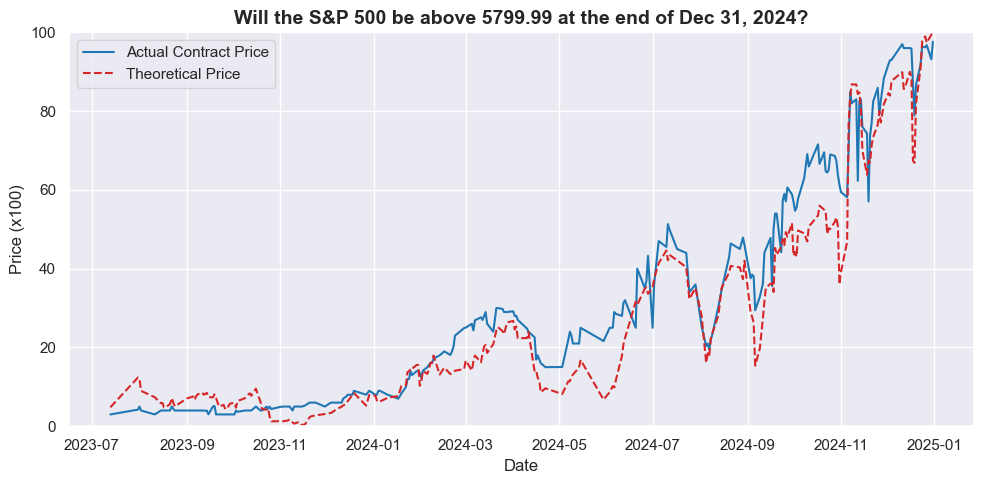

Correlation (r): 0.7657
Coefficient of Determination (R²): 0.5862
The model explains 58.6% of the variation in market prices


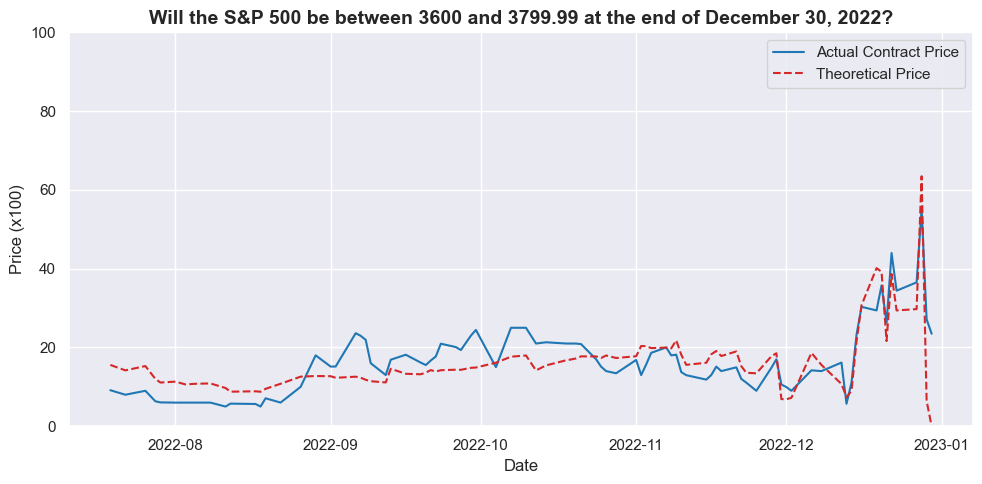

Correlation (r): 0.9412
Coefficient of Determination (R²): 0.8858
The model explains 88.6% of the variation in market prices


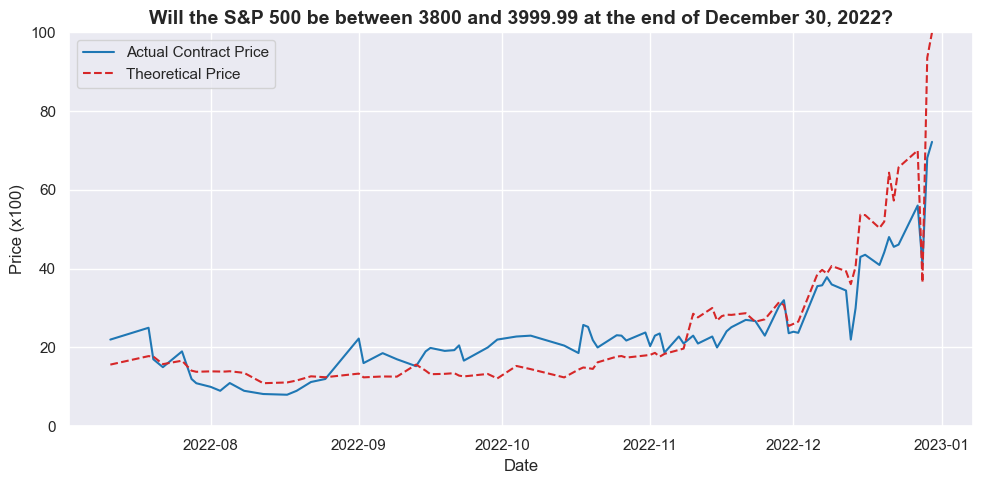

Correlation (r): 0.9048
Coefficient of Determination (R²): 0.8186
The model explains 81.9% of the variation in market prices


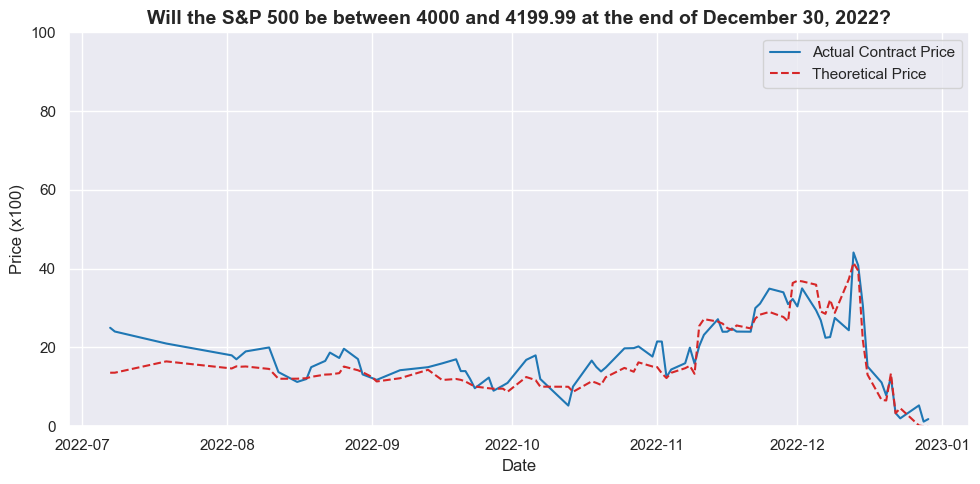

Correlation (r): 0.9290
Coefficient of Determination (R²): 0.8631
The model explains 86.3% of the variation in market prices


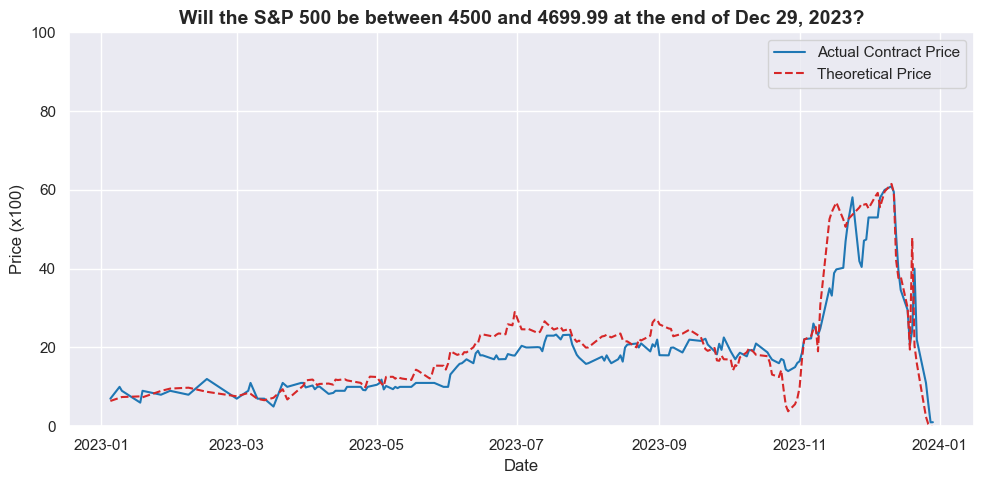

Correlation (r): 0.9657
Coefficient of Determination (R²): 0.9325
The model explains 93.3% of the variation in market prices


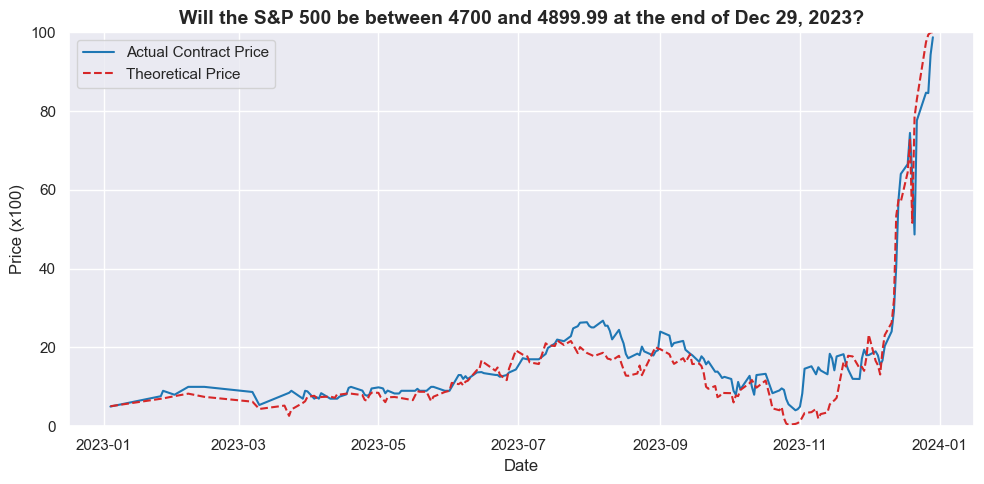

In [34]:
import matplotlib.pyplot as plt

groups = merged.groupby('ticker')

for ticker, group in groups:
    fig, ax = plt.subplots(figsize=(10, 5))

    title = group['title'].iloc[0]
    ax.set_title(f"{title}", fontsize=14, weight='bold')
    ax.set_xlabel("Date")

    # Plot both prices on the same axis
    ax.plot(group['Date'], group['contract_price'], color='tab:blue', label='Actual Contract Price')
    ax.plot(group['Date'], group['estimated_option_price'], color='tab:red', linestyle='--', label='Theoretical Price')
    ax.set_ylabel("Price (x100)")
    ax.set_ylim(0, 100)
    ax.legend(loc='best')

    valid_data = group[['contract_price', 'estimated_option_price']].dropna()
    r = valid_data['contract_price'].corr(valid_data['estimated_option_price'])
    r_squared = r**2
    
    # Print with proper formatting and clear labels
    print(f"Correlation (r): {r:.4f}")
    print(f"Coefficient of Determination (R²): {r_squared:.4f}")
    print(f"The model explains {r_squared*100:.1f}% of the variation in market prices")

    fig.tight_layout()
    plt.show()


In [35]:
merged['ticker'].value_counts()

ticker
INXD-24DEC31-T5799.99    242
INXY-23DEC29-B4600       179
INXY-23DEC29-B4800       174
INXY-22DEC30-B4100        86
INXY-22DEC30-B3700        86
INXY-22DEC30-B3900        81
Name: count, dtype: int64

(-2.7860396022831253, 0.06029574806681222, 8, 233, {'1%': -3.458731141928624, '5%': -2.8740258764297293, '10%': -2.5734243167124093}, 1316.0661043551972)


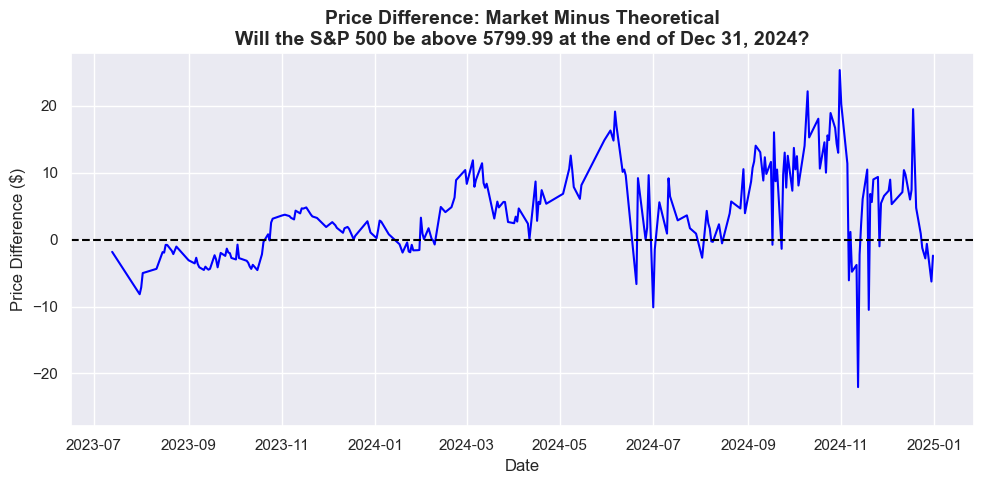

(-4.669001286738314, 9.6190474613258e-05, 1, 177, {'1%': -3.467845319799907, '5%': -2.878011745497439, '10%': -2.575551186759871}, 950.0248338498861)


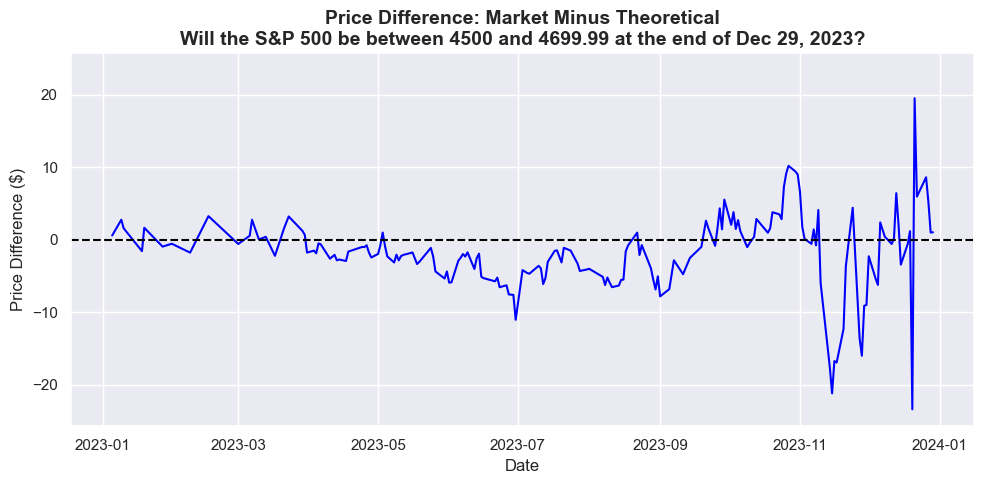

In [36]:
import matplotlib.pyplot as plt

groups = merged.groupby('ticker')

for ticker, group in groups:
  if ticker in ['INXD-24DEC31-T5799.99', 'INXY-23DEC29-B4600']:

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot price difference
    price_diff = group['contract_price'] - group['estimated_option_price']
    print(adfuller(price_diff))
    ax.plot(group['Date'], price_diff, color='blue')
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='--')
    
    # Center y-axis at zero
    y_max = max(abs(price_diff.min()), abs(price_diff.max())) * 1.1
    ax.set_ylim(-y_max, y_max)
    
    # Labels
    title = group['title'].iloc[0]
    ax.set_title(f"Price Difference: Market Minus Theoretical\n{title}", 
                fontsize=14, weight='bold')  
    ax.set_xlabel("Date")
    ax.set_ylabel("Price Difference ($)")
    
    plt.tight_layout()
    plt.show()

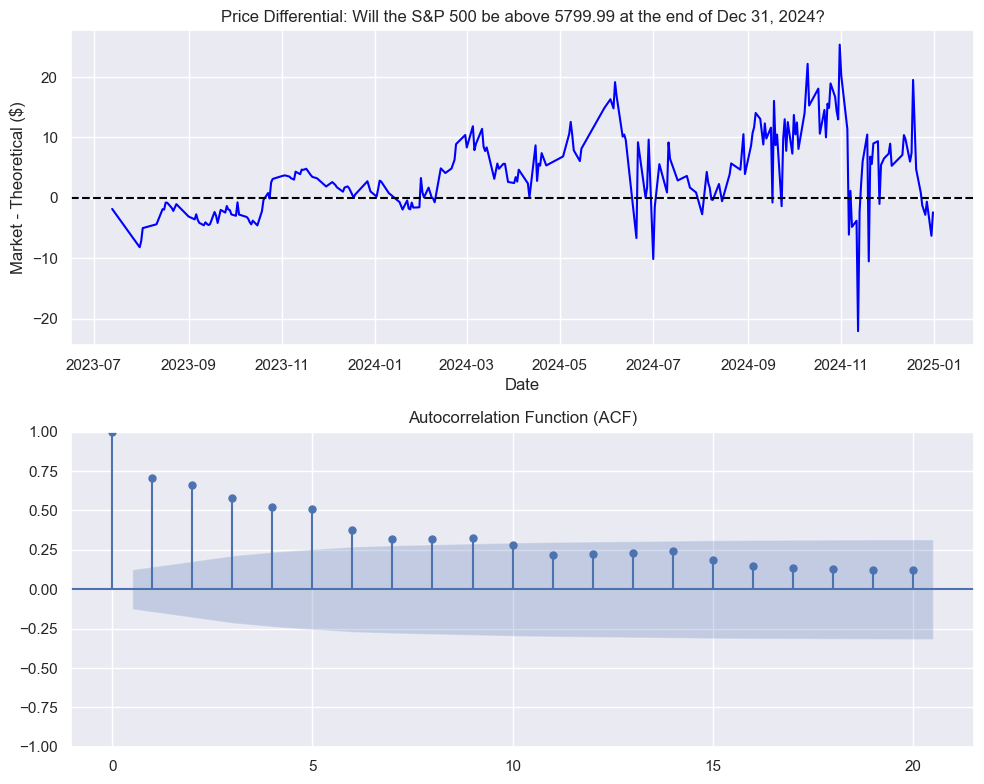

Ljung-Box Test for INXD-24DEC31-T5799.99:
Lag 1 - Statistic: 123.0767, p-value: 0.0000
Lag 5 - Statistic: 446.1505, p-value: 0.0000
Lag 10 - Statistic: 579.8892, p-value: 0.0000



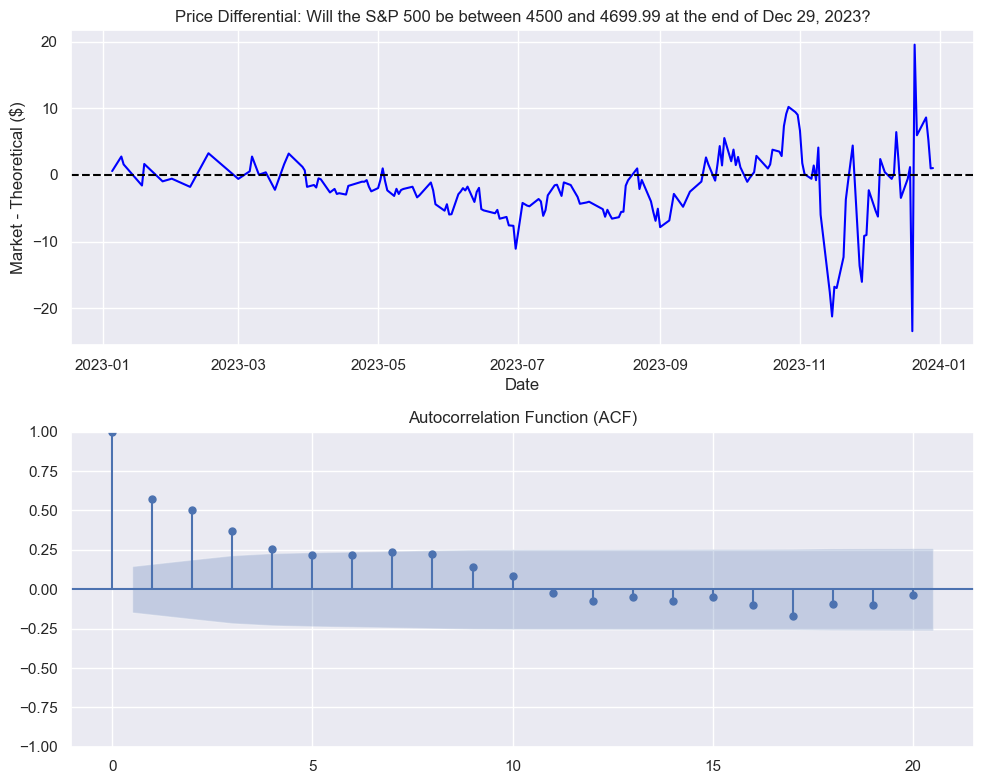

Ljung-Box Test for INXY-23DEC29-B4600:
Lag 1 - Statistic: 59.3874, p-value: 0.0000
Lag 5 - Statistic: 151.8778, p-value: 0.0000
Lag 10 - Statistic: 185.5343, p-value: 0.0000



In [37]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

groups = merged.groupby('ticker')

for ticker, group in groups:
    if ticker in ['INXD-24DEC31-T5799.99', 'INXY-23DEC29-B4600']:
        price_diff = group['contract_price'] - group['estimated_option_price']
        
        # Create figure with 2 subplots
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot price differential
        axes[0].plot(group['Date'], price_diff, color='blue')
        axes[0].axhline(y=0, color='black', linestyle='--')
        axes[0].set_title(f"Price Differential: {group['title'].iloc[0]}")
        axes[0].set_xlabel("Date")
        axes[0].set_ylabel("Market - Theoretical ($)")
        
        # Plot autocorrelation function
        plot_acf(price_diff.dropna(), lags=20, ax=axes[1], title=f"Autocorrelation Function (ACF)")
        
        plt.tight_layout()
        plt.show()
        
        # Ljung-Box test for autocorrelation
        lb_test = sm.stats.acorr_ljungbox(price_diff.dropna(), lags=[1, 5, 10])
        print(f"Ljung-Box Test for {ticker}:")
        print(f"Lag 1 - Statistic: {lb_test.iloc[0, 0]:.4f}, p-value: {lb_test.iloc[0, 1]:.4f}")
        print(f"Lag 5 - Statistic: {lb_test.iloc[1, 0]:.4f}, p-value: {lb_test.iloc[1, 1]:.4f}")
        print(f"Lag 10 - Statistic: {lb_test.iloc[2, 0]:.4f}, p-value: {lb_test.iloc[2, 1]:.4f}")
        print()